# **Vision Transformers for End-to-End Particle Identification with the CMS Experiment**

In [1]:
# I need to downscale tensorflow to 2.9.1 as i was using TPU on kaggle
from IPython.display import clear_output
!pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install scikit-learn
!pip install -U -q tensorflow-addons
clear_output()

In [2]:
# Import Neccessary Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import h5py
import math
import urllib.request
import tensorflow_addons as tfa
from PIL import Image

[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


In [3]:
# initialize TPU
print('TensorFlow Version:', tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)

except Exception as e:
    print(e)
    strategy = tf.distribute.get_strategy()

TensorFlow Version: 2.9.1
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:

In [4]:
DATA_DIR = '/kaggle/input/electron-vs-photons-ml4sci'

In [5]:
# Define the filenames and batch size
electrons_filename = f'{DATA_DIR}/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
photons_filename = f'{DATA_DIR}/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
batch_size = 16 * strategy.num_replicas_in_sync
num_features = 32

# Define a generator function to load and process data in batches
def batch_generator(electrons_filename, photons_filename, batch_size):
    # Open the HDF5 files and get the number of samples
    electrons_file = h5py.File(electrons_filename, 'r')
    photons_file = h5py.File(photons_filename, 'r')
    num_electrons = electrons_file['X'].shape[0]
    num_photons = photons_file['X'].shape[0]

    # Calculate the number of batches per epoch
    num_batches = max(num_electrons, num_photons) // batch_size

    # Loop over the data and yield batches
    for i in range(num_batches):
        # Load a batch of electrons and photons
        electrons_x = electrons_file['X'][i*batch_size:(i+1)*batch_size]
        electrons_y = electrons_file['y'][i*batch_size:(i+1)*batch_size]

        photons_x = photons_file['X'][i*batch_size:(i+1)*batch_size]
        photons_y = photons_file['y'][i*batch_size:(i+1)*batch_size]

        # Combine the data
        batch_x = np.concatenate([electrons_x, photons_x])
        batch_y = np.concatenate([electrons_y, photons_y])
        
        # expand dims of batch_y
        batch_y = np.expand_dims(batch_y, axis=1)
        
        # shuffle it
        perm = np.random.permutation(len(batch_x))
        batch_x = batch_x[perm]
        batch_y = batch_y[perm]
        
        # Convert the data to TensorFlow tensors and yield it
        yield tf.convert_to_tensor(batch_x, dtype=tf.float32), tf.convert_to_tensor(batch_y, dtype=tf.int32)

    # Close the HDF5 files
    electrons_file.close()
    photons_file.close()

# Create a TensorFlow Dataset from the generator function
batched_dataset = tf.data.Dataset.from_generator(
    lambda: batch_generator(electrons_filename, photons_filename, batch_size//2),
    output_types=(tf.float32, tf.int32),
    output_shapes=((batch_size, num_features, num_features, 2), (batch_size, 1))
).repeat()

In [7]:
image_size = 32
patch_size = 6
num_patches = (image_size // patch_size) ** 2
embedding_dim = 64
num_layers = 1

In [8]:
# CITE: https://keras.io/examples/vision/image_classification_with_vision_transformer/

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Imaaddge size: 32 X 32
Patch size: 6 X 6
Patches per image: 25
Elements per patch: 108


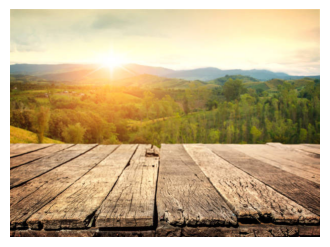

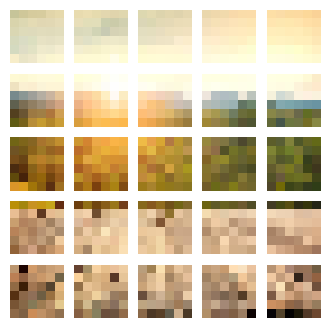

In [9]:
# Sample of Patches looks like
url = 'https://media.istockphoto.com/id/889003612/photo/table-top-and-blur-nature-of-the-background.jpg?s=612x612&w=0&k=20&c=edYqQ59SUatNJUGGcbLKe9Xz73HKxXF02u21FuXqokE='
filename = 'sample.jpg'
urllib.request.urlretrieve(url, filename)

plt.figure(figsize=(4, 4))
image = np.array(Image.open(filename))
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Imaaddge size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x


class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x


class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x


class Encoder(tf.keras.layers.Layer):
    def __init__(
        self, 
        *, 
        num_layers, 
        d_model, 
        num_heads,
        dff, 
        dropout_rate=0.1
    ):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x

    
class VisionTransformer(tf.keras.Model):
    
    def __init__(
        self, 
        *, 
        num_layers, 
        d_model, 
        num_heads, 
        dff,
        dropout_rate=0.1,
        num_patches
    ):
        super().__init__()
        self.patch_encoder = PatchEncoder(num_patches, d_model)
        
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               dropout_rate=dropout_rate)
        
        self.final_layer = tf.keras.layers.Dense(2)
    
    def call(self, inputs):
        patches = Patches(patch_size)(inputs)
        encoded_patches = self.patch_encoder(patches)
        x = self.encoder(encoded_patches)
        x = tf.keras.layers.Flatten()(x)
        logits = self.final_layer(x)
        return logits

In [11]:
train_frac = 0.06 # using only 0.06% of the entire dataset

# calculating dataset size
dataset_size = math.ceil((h5py.File(electrons_filename, 'r')['X'].shape[0]*2)/batch_size)

# Define the size of the training and testing datasets
train_size = math.ceil(dataset_size * train_frac)
test_size = math.floor(dataset_size * (1 - train_frac))

train_dataset = batched_dataset.take(train_size)
test_dataset = batched_dataset.skip(train_size).take(test_size)

In [16]:
with strategy.scope():

    model = VisionTransformer(
        num_layers=2, 
        d_model=embedding_dim, 
        num_heads=8, 
        dff=1024,
        dropout_rate=0.1,
        num_patches=num_patches
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    model.build((None, 32, 32, 2))

In [17]:
model.summary()

Model: "vision_transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder_1 (PatchEncod  multiple                 6272      
 er)                                                             
                                                                 
 encoder_1 (Encoder)         multiple                  530176    
                                                                 
 dense_11 (Dense)            multiple                  3202      
                                                                 
Total params: 539,650
Trainable params: 539,650
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(
    train_dataset,
    epochs=10
)

Epoch 1/10


2023-03-29 10:41:45.981572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-03-29 10:41:46.155519: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


234/234 [==============================] - 81s 314ms/step - loss: 0.7683 - accuracy: 0.5454
Epoch 2/10
234/234 [==============================] - 75s 321ms/step - loss: 0.6699 - accuracy: 0.5945
Epoch 3/10
234/234 [==============================] - 75s 319ms/step - loss: 0.6617 - accuracy: 0.6046
Epoch 4/10
234/234 [==============================] - 75s 320ms/step - loss: 0.6558 - accuracy: 0.6129
Epoch 5/10
234/234 [==============================] - 75s 320ms/step - loss: 0.6500 - accuracy: 0.6184
Epoch 6/10
234/234 [==============================] - 75s 317ms/step - loss: 0.6460 - accuracy: 0.6250
Epoch 7/10
234/234 [==============================] - 75s 317ms/step - loss: 0.6437 - accuracy: 0.6293
Epoch 8/10
234/234 [==============================] - 75s 319ms/step - loss: 0.6374 - accuracy: 0.6328
Epoch 9/10
234/234 [==============================] - 75s 319ms/step - loss: 0.6330 - accuracy: 0.6399
Epoch 10/10
234/234 [==============================] - 75s 319ms/step - loss: 0.6271

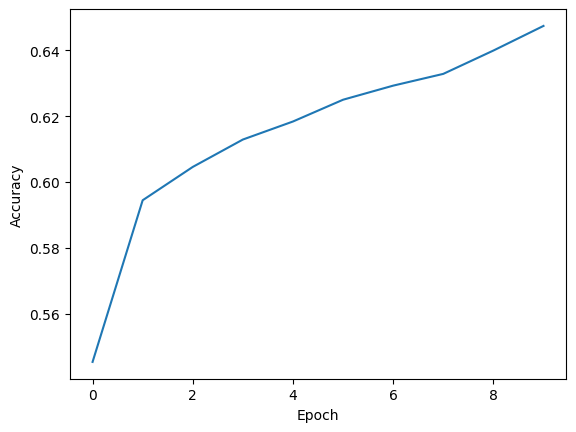

In [26]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

**From the accuracy curve above, it is apparent that the model's performance continues to improve with more epochs of training. This suggests that if we continue training the model for more epochs, we can expect further improvement in its performance.**